In [18]:
import matplotlib.pyplot as plt
import matplotlib.patches as ptch
import numpy as np
import scipy.io as io
from scipy import interpolate

# Modulation envelope function

As per the paper the directional modulation envelope can be calculated as follows:
$$
\big|\vec{E}_{AM}(\vec{n}, \vec{r})\big| = \big|\big|\big(\vec{E_1}(\vec{r}) + \vec{E_2}(\vec{r})\big)\cdot\vec{n}\big| - \big|\big(\vec{E_1}(\vec{r}) - \vec{E_2}(\vec{r})\big)\cdot\vec{n}\big|\big|
$$

The maximum modulation envelope for the condition $\big|\vec{E_1}\big| > \big|\vec{E_2}\big|$ and $\cos{a} < \pi/2$ is calculated as follows:
$$
\big|\vec{E}_{AM}^{max}(\vec{r})\big|=
\begin{cases}
      2\big|\vec{E_2}(\vec{r})\big| & \text{if}\; \big|\vec{E_2}(\vec{r})\big| < \big|\vec{E_1}(\vec{r})\big|\cos\alpha \\
      2\dfrac{\big|\big|\vec{E_2}(\vec{r})\big|\times\big(\vec{E_1}(\vec{r}) - \vec{E_2}(\vec{r})\big)\big|}{\big|\vec{E_1}(\vec{r}) - \vec{E_2}(\vec{r})\big|} & \text{otherwise}
\end{cases}
$$
and for the $\big|\vec{E_1}\big| < \big|\vec{E_2}\big|$ is:
$$
\big|\vec{E}_{AM}^{max}(\vec{r})\big|=
\begin{cases}
      2\big|\vec{E_1}(\vec{r})\big| & \text{if}\; \big|\vec{E_1}(\vec{r})\big| < \big|\vec{E_2}(\vec{r})\big|\cos\alpha \\
      2\dfrac{\big|\big|\vec{E_1}(\vec{r})\big|\times\big(\vec{E_2}(\vec{r}) - \vec{E_1}(\vec{r})\big)\big|}{\big|\vec{E_2}(\vec{r}) - \vec{E_1}(\vec{r})\big|} & \text{otherwise}
\end{cases}
$$

In [33]:
def modulation_envelope(e_field_1, e_field_2, dir_vector=None):
    """
    """
    if dir_vector is None:
        envelope = np.zeros(e_field_1.shape[0])
        
        # Calculate the angles between the two fields for each vector
        dot_angle = np.einsum('ij,ij->i', e_field_1, e_field_2)
        cross_angle = np.linalg.norm(np.cross(e_field_1, e_field_2), axis=1)
        angles = np.arctan2(cross_angle, dot_angle)
        
        # Flip the direction of the electric field if the angle between the two is greater or equal to 90 degrees
        e_field_2 = np.where(np.broadcast_to(angles >= np.pi/2., (3, e_field_2.shape[0])).T, -e_field_2, e_field_2)
        
        # Recalculate the angles
        dot_angle = np.einsum('ij,ij->i', e_field_1, e_field_2)
        cross_angle = np.linalg.norm(np.cross(e_field_1, e_field_2), axis=1)
        angles = np.arctan2(cross_angle, dot_angle)

        E_minus = np.subtract(e_field_1, e_field_2) # Create the difference of the E fields
        
        # Condition to have two times the E2 field amplitude
        max_condition_1 = np.linalg.norm(e_field_2, axis=1) < np.linalg.norm(e_field_1, axis=1)*np.cos(angles)
        e1_gr_e2 = np.where(np.linalg.norm(e_field_1, axis=1) > np.linalg.norm(e_field_2, axis=1), max_condition_1, False)
        
        # Condition to have two times the E1 field amplitude
        max_condition_2 = np.linalg.norm(e_field_1, axis=1) < np.linalg.norm(e_field_2, axis=1)*np.cos(angles)
        e2_gr_e1 = np.where(np.linalg.norm(e_field_2, axis=1) > np.linalg.norm(e_field_1, axis=1), max_condition_2, False)
        
        # Double magnitudes
        envelope = np.where(e1_gr_e2, 2.0*np.linalg.norm(e_field_2, axis=1), envelope) # 2E2 (First case)
        envelope = np.where(e2_gr_e1, 2.0*np.linalg.norm(e_field_1, axis=1), envelope) # 2E1 (Second case)
        
        # Calculate the complement area to the previous calculation
        e1_gr_e2 = np.where(np.linalg.norm(e_field_1, axis=1) > np.linalg.norm(e_field_2, axis=1), np.logical_not(max_condition_1), False)
        e2_gr_e1 = np.where(np.linalg.norm(e_field_2, axis=1) > np.linalg.norm(e_field_1, axis=1), np.logical_not(max_condition_2), False)
        
        # Cross product
        envelope = np.where(e1_gr_e2, 2.0*(np.linalg.norm(np.cross(e_field_2, E_minus), axis=1)/np.linalg.norm(E_minus, axis=1)), envelope) # (First case)
        envelope = np.where(e2_gr_e1, 2.0*(np.linalg.norm(np.cross(e_field_1, -E_minus), axis=1)/np.linalg.norm(-E_minus, axis=1)), envelope) # (Second case)
    else:
        # Calculate the values of the E field modulation envelope along the desired n direction
        E_plus = np.add(e_field_1, e_field_2) # Create the sum of the E fields
        E_minus = np.subtract(e_field_1, e_field_2) # Create the difference of the E fields
        envelope = np.abs(np.abs(np.dot(E_plus, dir_vector)) - np.abs(np.dot(E_minus, dir_vector)))
    return np.nan_to_num(envelope)

# Import the data and calculate the grid points
According to the documentation provided by Sim4Life, the grid point coordinates are calculated as
$$\Bigg[\dfrac{Axis0(1) + Axis0(2)}{2}, \dfrac{Axis1(1) + Axis1(2)}{2}, \dfrac{Axis2(1) + Axis2(2)}{2}\bigg]$$
for each point.

In [20]:
# Import the required files
base_data = io.loadmat('../MATLAB Workspaces and Scripts/Workspaces/BaseFrequency4Layer_Smaller.mat')
delta_data = io.loadmat('../MATLAB Workspaces and Scripts/Workspaces/DeltaFrequency4Layer_Smaller.mat')

# Replace possible NaN with 0
e_field_base = np.nan_to_num(base_data['EM_E_x_y_z_f0_Snapshot0'])
e_field_delta = np.nan_to_num(delta_data['EM_E_x_y_z_f0_Snapshot0'])

# Save the real part since the imaginary part is zero in the Ohmic current dominated domain
# Comment out the following if the simulation used produces complex valued field
e_field_base = np.real(e_field_base)
e_field_delta = np.real(e_field_delta)

# Same grid, so smae points. Assuming that both simulations have the exact same grid
x_axis = base_data['Axis0'][0]
y_axis = base_data['Axis1'][0]
z_axis = base_data['Axis2'][0]

######## Geometrical points coordinates
# Generate grid points
x_avg = 0.5*np.add(x_axis[:-1], x_axis[1:])
y_avg = 0.5*np.add(y_axis[:-1], y_axis[1:])
z_avg = 0.5*np.add(z_axis[:-1], z_axis[1:])

grid_points = np.array(np.meshgrid(x_avg, y_avg, z_avg, indexing='ij')).T.reshape(-1, 3)

x_grid = np.unique(grid_points.T[0])
y_grid = np.unique(grid_points.T[1])
z_grid = np.unique(grid_points.T[2])
######## Geometrical points coordinates

# Data calculations and graphs

## Directional modulation and maximum amplitude modulation

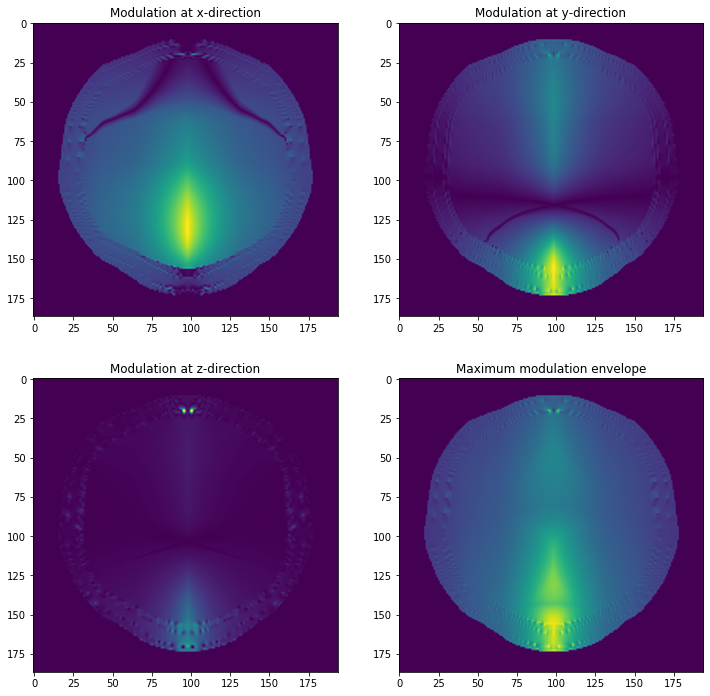

In [34]:
z_index = 76 # Z-slice index

E_am = modulation_envelope(e_field_base, e_field_delta).reshape(-1, x_grid.size) # Arrange the elements across the x axis

# Create the figure holders
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2, 2, 4)
ax2 = fig.add_subplot(2, 2, 1)
ax3 = fig.add_subplot(2, 2, 2)
ax4 = fig.add_subplot(2, 2, 3)

# Plot the images and add titles
ax1.imshow(E_am[(z_index - 1)*y_grid.size:z_index*y_grid.size].T, interpolation="spline36", cmap='viridis')
ax1.set_title('Maximum modulation envelope')

ax2.imshow(modulation_envelope(e_field_base, e_field_delta, [1, 0, 0]).reshape(-1, x_grid.size)[(z_index - 1)*y_grid.size:z_index*y_grid.size].T, 
           interpolation="spline36", cmap='viridis')
ax2.set_title('Modulation at x-direction')

ax3.imshow(modulation_envelope(e_field_base, e_field_delta, [0, 1, 0]).reshape(-1, x_grid.size)[(z_index - 1)*y_grid.size:z_index*y_grid.size].T, 
           interpolation="spline36", cmap='viridis')
ax3.set_title('Modulation at y-direction')

ax4.imshow(modulation_envelope(e_field_base, e_field_delta, [0, 0, 1]).reshape(-1, x_grid.size)[(z_index - 1)*y_grid.size:z_index*y_grid.size].T, 
           interpolation="spline36", cmap='viridis')
ax4.set_title('Modulation at z-direction')

plt.show() # Show the plots

## Vector field and maximum modulation calculations

### Grid regulariaztion function

In [22]:
# Data interpolation
def grid_regularization(axis_1, axis_2, data_points, data_type='vector', method='linear'):
    """
    """
    axis_1_step = np.uint32(np.ceil(1. + (axis_1[-1] - axis_1[0])/np.amin(np.diff(axis_1))))
    axis_2_step = np.uint32(np.ceil(1. + (axis_2[-1] - axis_2[0])/np.amin(np.diff(axis_2))))

    axis_1_interp = np.linspace(axis_1[0], axis_1[-1], axis_1_step)
    axis_2_interp = np.linspace(axis_2[0], axis_2[-1], axis_2_step)

    if data_type == 'vector':
        data_points_u = interpolate.interp2d(axis_1, axis_2, data_points[:, 0].reshape(-1, axis_1.size), kind=method)
        data_points_u = data_points_u(axis_1_interp, axis_2_interp).reshape(-1, 1)

        data_points_v = interpolate.interp2d(axis_1, axis_2, data_points[:, 1].reshape(-1, axis_1.size), kind=method)
        data_points_v = data_points_v(axis_1_interp, axis_2_interp).reshape(-1, 1)
        
        interp_grid = np.hstack((data_points_u, data_points_v))
    elif data_type == 'image':
        interp_grid = interpolate.interp2d(axis_1, axis_2, data_points.reshape(-1, axis_1.size), kind=method)
        interp_grid = interp_grid(axis_1_interp, axis_2_interp).reshape(-1, 1)
    else:
        print("Invalid type provided!")
        return None

    return axis_1_interp, axis_2_interp, interp_grid

### Point reduction function

In [23]:
def point_reduction(axis_1, axis_2, grid_points, cut_point):
    # New axis points
    axis_1_cut = np.where(np.logical_or(axis_1 < -cut_point, axis_1 > cut_point), False, True)
    axis_2_cut = np.where(np.logical_or(axis_2 < -cut_point, axis_2 > cut_point), False, True)

    axis_1_cut = axis_1[axis_1_cut]
    axis_2_cut = axis_2[axis_2_cut]

    # New data points
    x_grid_new = grid_points[(z_index - 1)*y_grid.size*x_grid.size:z_index*y_grid.size*x_grid.size][:, 0]
    y_grid_new = grid_points[(z_index - 1)*y_grid.size*x_grid.size:z_index*y_grid.size*x_grid.size][:, 1]

    axis_1_grid_new = np.invert(np.logical_or(grid_points[:, 0] < -cut_point, grid_points[:, 0] > cut_point))
    axis_2_grid_new = np.invert(np.logical_or(grid_points[:, 1] < -cut_point, grid_points[:, 1] > cut_point))
    common_grid_points = np.logical_and(axis_1_grid_new, axis_2_grid_new)
    
    return axis_1_cut, axis_2_cut, common_grid_points

### Maximum modulation envelope

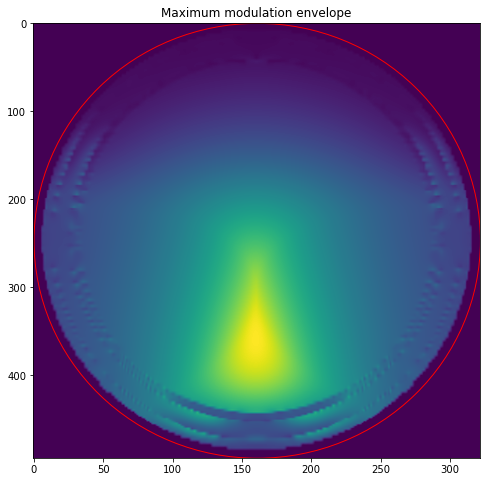

In [24]:
z_index = 76 # Z-slice index

########## New points
# Reduce the grid and find the new data and axis points
grid_cut = 0.09 # Point up to which the grid is used
x_cut, y_cut, common_grid_points = point_reduction(x_grid, y_grid, grid_points[(z_index - 1)*y_grid.size*x_grid.size:z_index*y_grid.size*x_grid.size], grid_cut)
########## New points

########## Calculate the data
calc_modenv = modulation_envelope(e_field_base, e_field_delta)
calc_modenv_slice = calc_modenv[(z_index - 1)*y_grid.size*x_grid.size:z_index*y_grid.size*x_grid.size]
calc_modenv_slice_reduced = calc_modenv_slice[common_grid_points]

axis_1_interp, axis_2_interp, calc_modenv_slice_interp = grid_regularization(x_cut, y_cut, calc_modenv_slice_reduced, data_type='image')
########## Calculate the data

########## Plot the results
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)

ax.imshow(calc_modenv_slice_interp.reshape(-1, axis_1_interp.size).T, cmap='viridis', interpolation="spline36", aspect='auto')
ax.set_title('Maximum modulation envelope')

# Add a circle denoting the edges
circ = ptch.Ellipse((axis_2_interp.size/2., axis_1_interp.size/2.), axis_2_interp.size, axis_1_interp.size, color='r', fill=False)
ax.add_patch(circ)

plt.show()
########## Plot the results

### Vector field

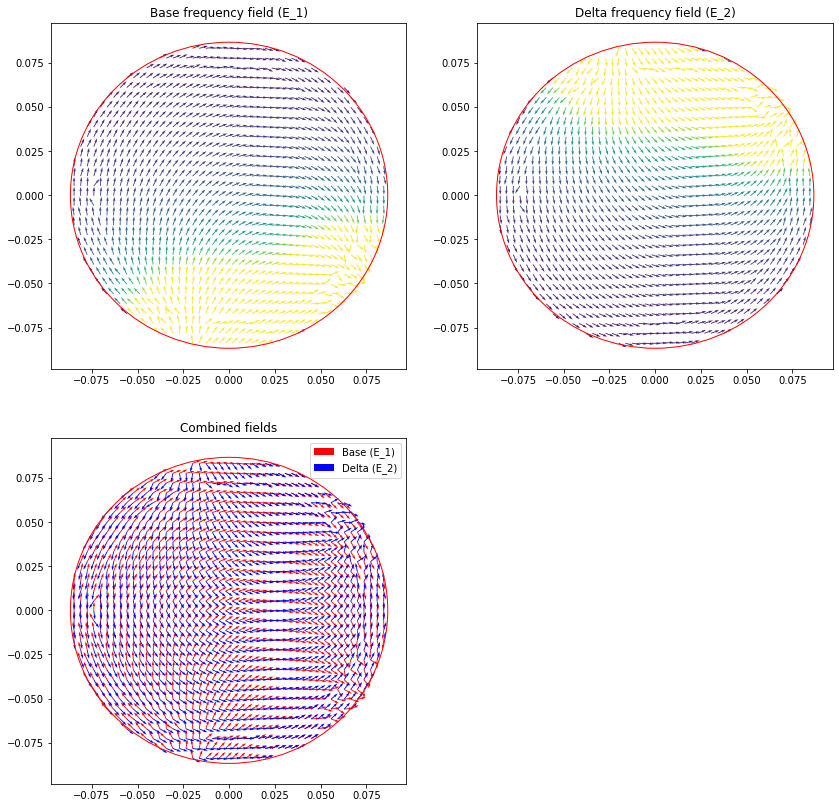

In [25]:
# Function to normalize the vector length
def normalize(x, y):
    return x / np.sqrt(x**2 + y**2), y / np.sqrt(x**2 + y**2)

# Get the field values for the specific Z slice
z_index = 76
base_field = np.nan_to_num(e_field_base[(z_index - 1)*y_grid.size*x_grid.size:z_index*y_grid.size*x_grid.size])
delta_field = np.nan_to_num(e_field_delta[(z_index - 1)*y_grid.size*x_grid.size:z_index*y_grid.size*x_grid.size])

# Skip grid points for better visualization
skip_int = 10 # Skipping step
skip_1 = (slice(None, None, skip_int))
skip_2 = (slice(None, None, skip_int), slice(None, None, skip_int))

########## New points
# Reduce the grid and find the new data and axis points
grid_cut = 0.09 # Point up to which the grid is used
x_cut, y_cut, common_grid_points = point_reduction(x_grid, y_grid, grid_points[(z_index - 1)*y_grid.size*x_grid.size:z_index*y_grid.size*x_grid.size], grid_cut)
########## New points

base_field = base_field[common_grid_points, :]
delta_field = delta_field[common_grid_points, :]

########## Plot the quiver plots
# Create the figure for the plot and add a subplot
fig = plt.figure(figsize=(14, 14))
ax_1 = fig.add_subplot(2, 2, 1)
ax_2 = fig.add_subplot(2, 2, 2)
ax_3 = fig.add_subplot(2, 2, 3)

x_int, y_int, base_uv = grid_regularization(x_cut, y_cut, base_field, data_type='vector')
ax_1.quiver(x_int[skip_1], y_int[skip_1], *normalize(base_uv[:, 0].reshape(-1, x_int.size)[skip_2], 
          base_uv[:, 1].reshape(-1, x_int.size)[skip_2]), 
          np.linalg.norm(base_uv[:, 0:2], axis=1).reshape(-1, x_int.size)[skip_2],
          units='width', scale=40, label='Base (E_1)', clim=[0, 0.5],cmap='viridis',
          color='red')
ax_3.quiver(x_int[skip_1], y_int[skip_1], *normalize(base_uv[:, 0].reshape(-1, x_int.size)[skip_2], 
            base_uv[:, 1].reshape(-1, x_int.size)[skip_2]), units='width', scale=40, 
            label='Base (E_1)', clim=[0, 0.5], color='red')

x_int, y_int, base_uv = grid_regularization(x_cut, y_cut, delta_field, data_type='vector')
ax_2.quiver(x_int[skip_1], y_int[skip_1], *normalize(base_uv[:, 0].reshape(-1, x_int.size)[skip_2],
          base_uv[:, 1].reshape(-1, x_int.size)[skip_2]),
          np.linalg.norm(base_uv[:, 0:2], axis=1).reshape(-1, x_int.size)[skip_2],
          units='width', scale=40, label='Delta (E_2)', clim=[0, 0.5],cmap='viridis',
          color='blue')
ax_3.quiver(x_int[skip_1], y_int[skip_1], *normalize(base_uv[:, 0].reshape(-1, x_int.size)[skip_2],
            base_uv[:, 1].reshape(-1, x_int.size)[skip_2]), units='width', scale=40, 
            label='Delta (E_2)', clim=[0, 0.5], color='blue')

# Plot a circle representing the modeled sphere
head_radius = 0.08675
circ = plt.Circle((0, 0), head_radius, color='r', fill=False)
ax_1.add_artist(circ)

circ = plt.Circle((0, 0), head_radius, color='r', fill=False)
ax_2.add_artist(circ)

circ = plt.Circle((0, 0), head_radius, color='r', fill=False)
ax_3.add_artist(circ)

# Add titles to plots
ax_1.set_title('Base frequency field (E_1)')
ax_2.set_title('Delta frequency field (E_2)')
ax_3.set_title('Combined fields')
ax_3.legend()

plt.show()
########## Plot the quiver plots